# BITCOIN PREDICTION
# IBM ADVANCE DATA SCIENCE CAPSTONE

Bitcoin has been gaining popularity since its establishment in 2008. Inspired by the demonstration in IBM Applied AI with Deeplearning course, this project project attempts to predict the Bitcoin price in the future based on historical data of price, sentiment and searching trend. 

In [1]:
# Import all the necessary libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from plotly import tools
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc
import seaborn as sns
from math import sqrt
from numpy import concatenate
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


## A: DATA SOURCE AND COLLECTION

Three kinds of historical data needs to be collected.<p>
- Bitcoin histroical price<p>
- Google Trend on Bitcoin, Buy Bitcoin and Sell Bitcoin<p>
- Bitcoin Sentiment<p>

In [2]:
#Collet Bitcoin historical price data
df_price = pd.read_csv('C:/Users/melvi/Documents/ADS Capstone/BTC-USD.csv')

#Collect Bitcoin historical sentiment data
df_sentiment = pd.read_csv('C:/Users/melvi/Documents/ADS Capstone/Sentiment.csv')

#Collect Bitcoin historical Google Trend data
df_GT = pd.read_csv('C:/Users/melvi/Documents/ADS Capstone/GT.csv')

In [3]:
df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018/2/1,10237.299810,10288.799810,8812.280273,9170.540039,9170.540039,9959400448
1,2018/2/2,9142.280273,9142.280273,7796.490234,8830.750000,8830.750000,12726899712
2,2018/2/3,8852.120117,9430.750000,8251.629883,9174.910156,9174.910156,7263790080
3,2018/2/4,9175.700195,9334.870117,8031.220215,8277.009766,8277.009766,7073549824
4,2018/2/5,8270.540039,8364.839844,6756.680176,6955.270020,6955.270020,9285289984


In [4]:
df_sentiment.head()

,Date,Greed
0,2018/2/1,30
1,2018/2/2,15
2,2018/2/3,40
3,2018/2/4,24
4,2018/2/5,11


In [5]:
df_GT.head()

,Date,Buy,Sell,BT
0,2018/2/1,18.998110,3.799622,28.0
1,2018/2/2,15.198488,2.374764,37.0
2,2018/2/3,17.098299,3.324669,24.0
3,2018/2/4,17.098299,1.424858,21.0
4,2018/2/5,18.998110,2.374764,37.0


In [6]:
# Combine all the data into one dataframes
df = df_price.merge(right = df_sentiment,how = "left",on = "Date")
df = df.merge(right = df_GT,how = "left",on = "Date")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Greed,Buy,Sell,BT
0,2018/2/1,10237.299810,10288.799810,8812.280273,9170.540039,9170.540039,9959400448,30,18.998110,3.799622,28.0
1,2018/2/2,9142.280273,9142.280273,7796.490234,8830.750000,8830.750000,12726899712,15,15.198488,2.374764,37.0
2,2018/2/3,8852.120117,9430.750000,8251.629883,9174.910156,9174.910156,7263790080,40,17.098299,3.324669,24.0
3,2018/2/4,9175.700195,9334.870117,8031.220215,8277.009766,8277.009766,7073549824,24,17.098299,1.424858,21.0
4,2018/2/5,8270.540039,8364.839844,6756.680176,6955.270020,6955.270020,9285289984,11,18.998110,2.374764,37.0


In [7]:
df.to_csv('C:/Users/melvi/Documents/ADS Capstone/Combined.csv', index=False)

In [8]:
df= pd.read_csv('C:/Users/melvi/Documents/ADS Capstone/Combined.csv', parse_dates=['Date'], index_col='Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume,Greed,Buy,Sell,BT
Date,,,,,,,,,,
2018-02-01,10237.299810,10288.799810,8812.280273,9170.540039,9170.540039,9959400448,30,18.998110,3.799622,28.0
2018-02-02,9142.280273,9142.280273,7796.490234,8830.750000,8830.750000,12726899712,15,15.198488,2.374764,37.0
2018-02-03,8852.120117,9430.750000,8251.629883,9174.910156,9174.910156,7263790080,40,17.098299,3.324669,24.0
2018-02-04,9175.700195,9334.870117,8031.220215,8277.009766,8277.009766,7073549824,24,17.098299,1.424858,21.0
2018-02-05,8270.540039,8364.839844,6756.680176,6955.270020,6955.270020,9285289984,11,18.998110,2.374764,37.0


## B: INITIAL DATA EXPLORATION

In [9]:
# Check the quality of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 677 entries, 2018-02-01 to 2019-12-09
Data columns (total 10 columns):
Open         677 non-null float64
High         677 non-null float64
Low          677 non-null float64
Close        677 non-null float64
Adj Close    677 non-null float64
Volume       677 non-null int64
Greed        677 non-null int64
Buy          677 non-null float64
Sell         677 non-null float64
BT           677 non-null float64
dtypes: float64(8), int64(2)
memory usage: 58.2 KB


In [56]:
# Normalize the data so they can be plotted on the same scale later
from sklearn.preprocessing import MinMaxScaler
price = df['Adj Close'].values.reshape(-1,1)
sentiment = df['Greed'].values.reshape(-1,1)
GT_BT = df['BT'].values.reshape(-1,1)
price = price.astype('float32')
sentiment = sentiment.astype('float32')
GT_BT = GT_BT.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
price = scaler.fit_transform(price)
sentiment = scaler.fit_transform(sentiment)
GT_BT = scaler.fit_transform(GT_BT)


In [11]:
#Visualize the trend of google trend, bitcoin price and sentiment
btc_trace = go.Scatter(x=df.index, y=price.flat, name= 'Price')
sentiment_trace = go.Scatter(x=df.index, y=sentiment.flat, name= 'Sentiment')
GT_trace = go.Scatter(x=df.index, y=GT_BT.flat, name= 'Google Trend')
py.iplot([btc_trace,sentiment_trace,GT_trace])

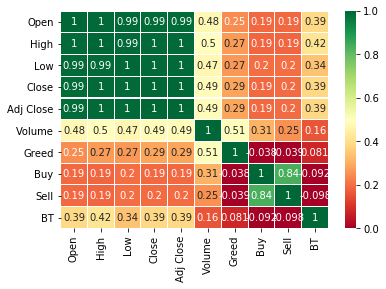

In [12]:
#Visualize the correlation between each features
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

In [13]:
#According to the correlation, It is found out that Open, High, Low, Close are the uneeded features in this case.

## C: DOCUMENTATION 

Please check the ADD submitted

## D: EXTRACT TRANSFORM LOAD
This section has been integrated in either previous or later sections

## E: DATA CLEANSING
As checked the before, there is no missing data or wrong data type<p>
Delete uneeded fetures is the only work needs to be done

In [14]:
df=df.drop(labels=['High','Low','Close','Open'],axis=1)
df.head()

,Adj Close,Volume,Greed,Buy,Sell,BT
Date,,,,,,
2018-02-01,9170.540039,9959400448,30,18.998110,3.799622,28.0
2018-02-02,8830.750000,12726899712,15,15.198488,2.374764,37.0
2018-02-03,9174.910156,7263790080,40,17.098299,3.324669,24.0
2018-02-04,8277.009766,7073549824,24,17.098299,1.424858,21.0
2018-02-05,6955.270020,9285289984,11,18.998110,2.374764,37.0


## F: FEATURE CREATION

## Tradition ML

In [15]:
ML_df = pd.read_csv('C:/Users/melvi/Documents/ADS Capstone/Combined.csv', parse_dates=['Date'], index_col='Date')
ML_price = ML_df["Adj Close"]

ML_df=ML_df.drop(labels=["Adj Close",'High','Low','Close','Volume','Open'],axis=1)

Y= ML_price
X= ML_df

x_train = ML_df[0:607]
y_train = ML_price[1:608]
x_test = ML_df[608:676]
y_test = ML_price[609:677]

## LSTM 

In [16]:
# A: Single feature: using the historical price as a feature to train
#Adjusted Close Price has been normalised to range from 0 to 1 in the previous step.
# B:Using additional features for model training
# convert to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [17]:
values = df[['Adj Close']+['BT']+['Volume']+['Greed']+['Sell']+['Buy']].values

values = values.astype('float32')

#Normalize features to range from 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#Frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

#Drop unncessary columns¶
reframed.drop(reframed.columns[7:], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)
1   0.606759   0.564095   0.166794   0.277778   0.171543   0.082245  0.572013
2   0.572013   0.770576   0.232403   0.111111   0.093885   0.039195  0.607206
3   0.607206   0.472326   0.102890   0.388889   0.145657   0.060720  0.515391
4   0.515391   0.403499   0.098380   0.211111   0.042113   0.060720  0.380236
5   0.380236   0.770576   0.150813   0.066667   0.093885   0.082245  0.461910


## G: MODEL DEFINITION

## Traditional ML

In [18]:
# Traditional ML
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor

C:\Users\melvi\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [19]:
models=[RandomForestRegressor(),LinearRegression(),KNeighborsRegressor(),Ridge(),Lasso(),MLPRegressor(alpha=20),DecisionTreeRegressor(),ExtraTreeRegressor(),XGBRegressor(),AdaBoostRegressor(),GradientBoostingRegressor(),BaggingRegressor()]
models_str=['RandomForest','LinearRegression','KNNRegressor','Ridge','Lasso','MLPRegressor','DecisionTree','ExtraTree','XGBoost','AdaBoost','GradientBoost','Bagging']
score_=[]

## LSTM single Feature

In [20]:
#lSTM
train_size = int(len(price) * 0.8)
test_size = len(price) - train_size
train, test = price[0:train_size,:], price[train_size:len(price),:]
print(len(train), len(test))

541 136


In [21]:
#Create function for creating dataset with look back

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [22]:
#Generate dataset for trainX, trainY, testX, testY
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

540
135


## LSTM Multiple Feature

In [23]:
#Split data to 80% training, 20% testing
values = reframed.values
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(540, 1, 6) (540,) (136, 1, 6) (136,)


## H: MODEL TRAINING

## Traditional ML

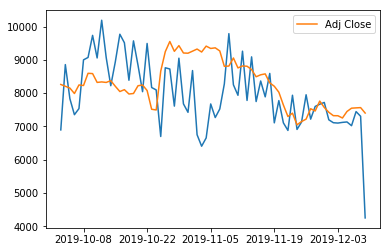

RandomForest Score:-1.5825135706603053


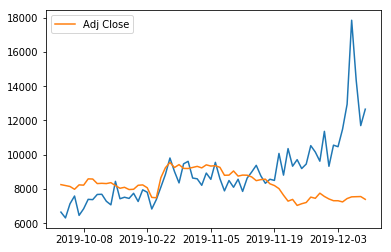

LinearRegression Score:-10.117696985175703


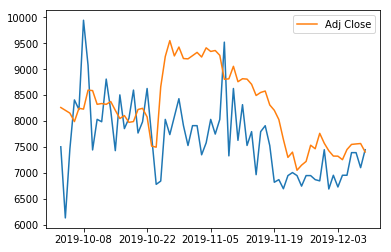

KNNRegressor Score:-0.9069519814098206


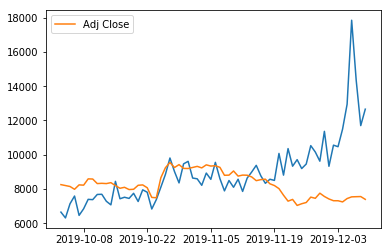

Ridge Score:-10.117990466707159


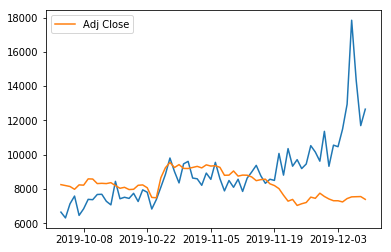

Lasso Score:-10.114441994658346


C:\Users\melvi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



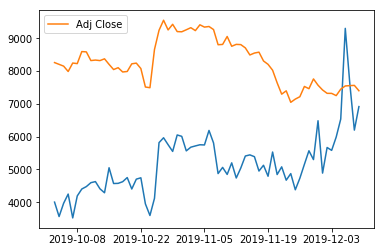

MLPRegressor Score:-21.410139531856476


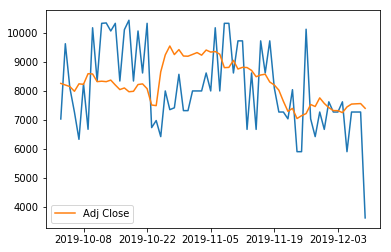

DecisionTree Score:-2.9608497665534057


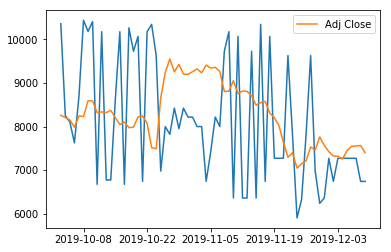

ExtraTree Score:-3.607776014633677
[12:15:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


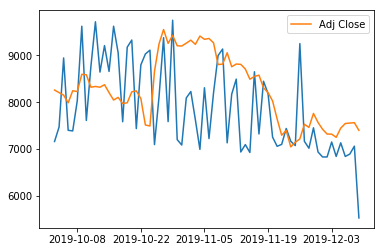

XGBoost Score:-1.399949618917102


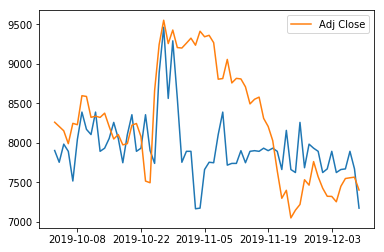

AdaBoost Score:-0.1868315550657067


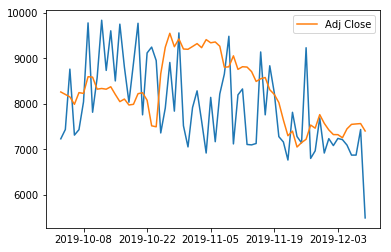

GradientBoost Score:-1.4042420294226217


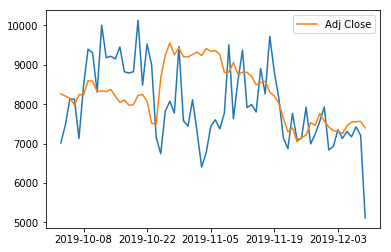

Bagging Score:-1.5378648150006704


In [24]:
for name,model in zip(models_str,models):
    model=model
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test) 
    score=model.score(x_test,y_test)
    score_.append(str(score)[:5])
    x = ML_df.index[609:677]
    y1 = y_pred
    y2 = y_test
    plt.plot(x, y1,y2)
    plt.legend()
    plt.show()

    print(name +' Score:'+str(score))

## LSTM single feature

In [25]:
#Reshape X for model training
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [102]:
#Running the LSTM model with 300 epochs
model = Sequential()
model.add(LSTM(500, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=100, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

## LSTM Multiple Feature

In [84]:
from keras.layers import LSTM, Dense, Dropout, Activation
multi_model = Sequential()
multi_model.add(LSTM(500, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)

## I: MODEL EVALUATION

 ## LSTM Single Feature

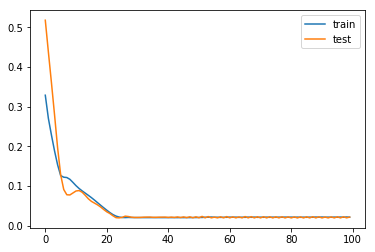

In [103]:
#Plot line graph to show amount loss according the the epoch¶

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

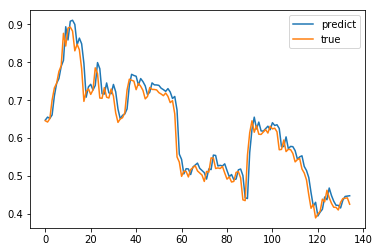

In [104]:
#Make prediction using textX and plotting line graph against testY¶

yhat = model.predict(testX)
plt.plot(yhat, label='predict')
plt.plot(testY, label='true')
plt.legend()
plt.show()
yhat = list(yhat.flat)

In [105]:
#RMSE
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.031


## LSTM Multiple Feature

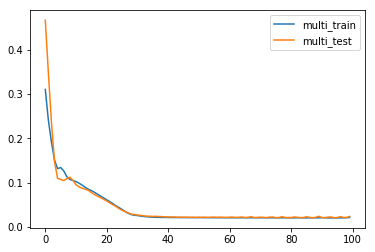

In [31]:
#Plot line graph to show amount loss according the the epoch
plt.plot(multi_history.history['loss'], label='multi_train')
plt.plot(multi_history.history['val_loss'], label='multi_test')
plt.legend()
plt.show()

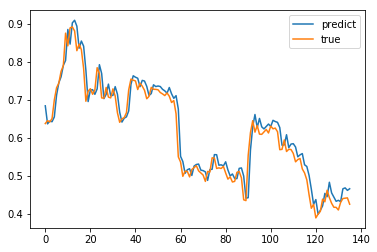

In [32]:
#Make prediction using textX and plotting line graph against testY

yhat_multi = multi_model.predict(test_X)
plt.plot(yhat_multi, label='predict')
plt.plot(test_y, label='true')
plt.legend()
plt.show()

In [33]:
#RMSE
rmse = sqrt(mean_squared_error(test_y, yhat_multi))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.031


In [77]:
#Training the LSTM model with 300 epochs
from keras.layers import LSTM, Dense, Dropout, Activation
multi_model = Sequential()
multi_model.add(LSTM(500, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=7,batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)

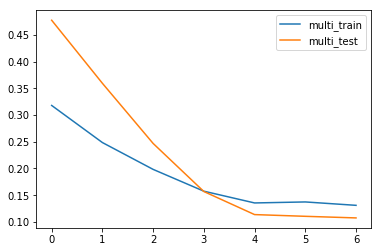

In [78]:
#Plot line graph to show amount loss according the the epoch
plt.plot(multi_history.history['loss'], label='multi_train')
plt.plot(multi_history.history['val_loss'], label='multi_test')
plt.legend()
plt.show()

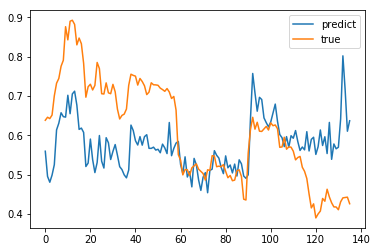

In [79]:
yhat_multi = multi_model.predict(test_X)
plt.plot(yhat_multi, label='predict')
plt.plot(test_y, label='true')
plt.legend()
plt.show()
yhat_multi = list(yhat_multi.flat)

In [108]:
actual_chart = go.Scatter(y=test_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(y=yhat_multi,name= 'Multi Predict Price')

py.iplot([multi_predict_chart,actual_chart])

## J: MODEL DEPLOYMENT
This Jupyter Notebook will be published on Github as the final product of this project

# FINAL DELIVERABLE
Youtube: <p>
Password: 